## 1. SETUP

### 1.1 Importar Libs

In [9]:
# Importação das bibliotecas necessárias
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
from joblib import load, dump
from scipy.stats import randint, uniform, loguniform
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

# Importar funções dos módulos customizados
from ml_utils import gmean_score, evaluate_model, load_and_prepare_datasets
from search_utils import (multiple_randomized_search, plot_search_history, save_search_results, 
                          save_final_results, DEFAULT_CV_STRATEGY, plot_search_history_from_loaded,
                          load_search_results, get_best_params_from_saved)

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

print("Bibliotecas importadas com sucesso!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

Bibliotecas importadas com sucesso!
Pandas: 2.3.2
NumPy: 2.3.3
Scikit-learn: 1.7.2


### 1.2 Configuração do Modelo

In [10]:
# Configuração do modelo e hiperparâmetros
MODEL_NAME = "LVQ"
# LVQ will be defined after the class implementation
RANDOM_STATE_MODEL = 42
RANDOM_STATE_SAMPLE = 10

# Configuração da busca de hiperparâmetros
N_SEARCHES = 20
N_ITER_PER_SEARCH = 5
SAMPLE_SIZE = 0.05  # % of training data 

# Pastas para salvamento
SEARCHES_FOLDER = 'searches'
RESULTS_FOLDER = 'results'
MODELS_FOLDER = 'models'

print(f"Modelo configurado: {MODEL_NAME}")
print(f"Buscas: {N_SEARCHES} x {N_ITER_PER_SEARCH} iterações")

Modelo configurado: LVQ
Buscas: 20 x 5 iterações


In [11]:
# Implementação da classe LVQ (Learning Vector Quantization)
class LVQClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, prototypes_per_class=10, n_epochs=100, learning_rate=0.1, random_state=None):
        self.prototypes_per_class = prototypes_per_class
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.random_state = random_state
        
    def fit(self, X, y):
        np.random.seed(self.random_state)
        
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        self.n_features_ = X.shape[1]
        
        # Inicializar protótipos
        self.prototypes_ = []
        self.prototype_labels_ = []
        
        for class_label in self.classes_:
            class_data = X[y == class_label]
            n_prototypes = min(self.prototypes_per_class, len(class_data))
            
            # Inicializar protótipos aleatoriamente a partir dos dados da classe
            indices = np.random.choice(len(class_data), n_prototypes, replace=False)
            class_prototypes = class_data[indices].copy()
            
            self.prototypes_.extend(class_prototypes)
            self.prototype_labels_.extend([class_label] * n_prototypes)
        
        self.prototypes_ = np.array(self.prototypes_)
        self.prototype_labels_ = np.array(self.prototype_labels_)
        
        # Treinamento LVQ
        for epoch in range(self.n_epochs):
            for i, (sample, label) in enumerate(zip(X, y)):
                # Encontrar protótipo mais próximo
                distances = np.sum((self.prototypes_ - sample) ** 2, axis=1)
                winner_idx = np.argmin(distances)
                winner_label = self.prototype_labels_[winner_idx]
                
                # Atualizar protótipo
                if winner_label == label:
                    # Aproximar protótipo do exemplo (recompensa)
                    self.prototypes_[winner_idx] += self.learning_rate * (sample - self.prototypes_[winner_idx])
                else:
                    # Afastar protótipo do exemplo (punição)
                    self.prototypes_[winner_idx] -= self.learning_rate * (sample - self.prototypes_[winner_idx])
        
        return self
    
    def predict(self, X):
        predictions = []
        
        for sample in X:
            distances = np.sum((self.prototypes_ - sample) ** 2, axis=1)
            winner_idx = np.argmin(distances)
            predictions.append(self.prototype_labels_[winner_idx])
        
        return np.array(predictions)
    
    def score(self, X, y):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X))

MODEL_CLASS = LVQClassifier

## 2. CARREGAMENTO E PREPARAÇÃO DOS DADOS

In [4]:
# Carregamento e preparação inicial dos dados
print("=== CARREGAMENTO DOS DATASETS ===")

# Carregar e preparar datasets usando função do módulo
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, train_data, test_data, scaler = load_and_prepare_datasets()

print(f"Dataset de treino: {train_data.shape}")
print(f"Dataset de teste: {test_data.shape}")
print(f"Features: {X_train_scaled.shape[1]}")

print("\nDistribuição das classes:")
print("Treino:", y_train.value_counts().to_dict())
print("Teste:", y_test.value_counts().to_dict())

# Mostrar sample dos dados
print("\nPrimeiras linhas do dataset de treino:")
display(train_data.head())

=== CARREGAMENTO DOS DATASETS ===
Dataset de treino: (72795, 17)
Dataset de teste: (8180, 17)
Features: 16

Distribuição das classes:
Treino: {0.0: 54175, 1.0: 18620}
Teste: {0.0: 5894, 1.0: 2286}

Primeiras linhas do dataset de treino:
Dataset de treino: (72795, 17)
Dataset de teste: (8180, 17)
Features: 16

Distribuição das classes:
Treino: {0.0: 54175, 1.0: 18620}
Teste: {0.0: 5894, 1.0: 2286}

Primeiras linhas do dataset de treino:


,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Gender,HospAdmTime,ICULOS,SepsisLabel
0,-0.828259,-0.396817,0.890288,-1.189896,0.268219,0.158164,0.391841,0.579093,1.632205,0.855053,0.706987,1.433318,0.068024,-1.140335,0.356849,-0.838308,0.0
1,-0.478847,-0.673800,-1.872530,0.324391,1.492201,-0.386455,-0.161934,-0.113524,-0.304515,1.156973,0.656064,-0.813046,1.079563,-1.140335,0.304841,-0.489607,0.0
2,-0.804965,0.544922,-0.644611,0.450581,1.249928,1.065862,-0.662070,-0.345514,0.976526,1.689773,1.623609,-1.137985,-0.149065,0.876935,0.357194,-0.815061,0.0
3,-0.525435,-0.396817,0.583308,-1.745135,-0.084618,0.702783,0.746309,0.543080,-1.476333,0.002573,-0.311482,-0.705572,-0.116992,0.876935,-0.584873,-0.536101,0.0
4,-0.665200,-1.061575,-0.644611,0.488439,0.387085,-0.567994,0.272113,-2.489717,-0.248842,0.748493,0.808834,-0.088417,0.940833,-1.140335,0.357194,-0.675581,0.0


## 3. SAMPLING PARA BUSCA DE HIPERPARÂMETROS

In [12]:
# ======================================================================
# SAMPLING ESTRATIFICADO PARA BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===")

# Amostra estratificada do dataset de treino
_, X_sample, _, y_sample = train_test_split(
    X_train_scaled, y_train,
    test_size=SAMPLE_SIZE,
    stratify=y_train,
    random_state=RANDOM_STATE_SAMPLE
)

print(f"Dataset original de treino: {X_train_scaled.shape[0]:,} amostras")
print(f"Amostra para busca de hiperparâmetros: {X_sample.shape[0]:,} amostras")
print(f"Redução: {(1 - X_sample.shape[0]/X_train_scaled.shape[0])*100:.1f}%")

print("\nDistribuição das classes na amostra:")
print("Amostra:", pd.Series(y_sample).value_counts().to_dict())
print("Original:", y_train.value_counts().to_dict())

=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===
Dataset original de treino: 72,795 amostras
Amostra para busca de hiperparâmetros: 3,640 amostras
Redução: 95.0%

Distribuição das classes na amostra:
Amostra: {0.0: 2709, 1.0: 931}
Original: {0.0: 54175, 1.0: 18620}


## 4. DEFINIR ESTRATÉGIA DE VALIDAÇÃO CRUZADA

In [14]:
# Usar estratégia de CV padrão dos módulos
cv_strategy = DEFAULT_CV_STRATEGY
print(f"Estratégia de CV: {cv_strategy}")

Estratégia de CV: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


## 5. LVQ - BUSCA DE HIPERPARÂMETROS

### 5.1 Definir Espaço de Hiperparâmetros

In [ ]:
# ======================================================================
# DEFINIÇÃO DO ESPAÇO DE HIPERPARÂMETROS
# ======================================================================

# Definir hiperparâmetros específicos para LVQ
param_distributions = {
    'prototypes_per_class': randint(50, 100),        # Número de protótipos por classe
    'n_epochs': randint(150, 1000),                  # Número de épocas
    'learning_rate': uniform(0.001, 0.1)              # Taxa de aprendizagem
}


### 5.2 Executar Busca de Hiperparâmetros

In [16]:
# ======================================================================
# BUSCA DE HIPERPARAMETROS
# ======================================================================

print(f"=== BUSCA DE HIPERPARÂMETROS - {MODEL_NAME} ===")
print(f"Iniciando busca de hiperparâmetros para {MODEL_NAME}...")
print(f"Executando {N_SEARCHES} buscas com {N_ITER_PER_SEARCH} iterações cada...")
print(f"Usando amostra de {X_sample.shape[0]:,} exemplos\n")

# Múltiplas execuções do RandomizedSearchCV
search, all_searches, best_params = multiple_randomized_search(
    estimator=MODEL_CLASS(),
    param_distributions=param_distributions,
    X=X_sample,
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=N_SEARCHES,
    n_iter_per_search=N_ITER_PER_SEARCH,
    scoring='f1',
    random_state=None,
    n_jobs=-1
)

# Exibir os melhores resultados
print(f"\n--- RESULTADOS {MODEL_NAME} ---")
print("Melhores hiperparâmetros encontrados:")
for param, value in search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nMelhor F1-Score (CV): {search.best_score_:.4f}")
print(f"Desvio padrão: {search.cv_results_['std_test_score'][search.best_index_]:.4f}")

=== BUSCA DE HIPERPARÂMETROS - LVQ ===
Iniciando busca de hiperparâmetros para LVQ...
Executando 20 buscas com 5 iterações cada...
Usando amostra de 3,640 exemplos

Executando 20 buscas com 5 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.4273
Melhor configuração desta busca: {'learning_rate': np.float64(0.2682526297935953), 'n_epochs': 514, 'prototypes_per_class': 77}
Melhor score geral até agora: 0.4273

Busca 2/20...
Melhor score desta busca: 0.4273
Melhor configuração desta busca: {'learning_rate': np.float64(0.2682526297935953), 'n_epochs': 514, 'prototypes_per_class': 77}
Melhor score geral até agora: 0.4273

Busca 2/20...
Melhor score desta busca: 0.5080
Melhor configuração desta busca: {'learning_rate': np.float64(0.10113665149093032), 'n_epochs': 956, 'prototypes_per_class': 66}
Melhor score geral até agora: 0.5080

Busca 3/20...
Melhor score desta busca: 0.5080
Melhor configuração desta busca: {'learning_rate': np.float64(0.10113665149093032), 'n_epochs': 956, '

### 5.3 Visualizar Histórico da Busca

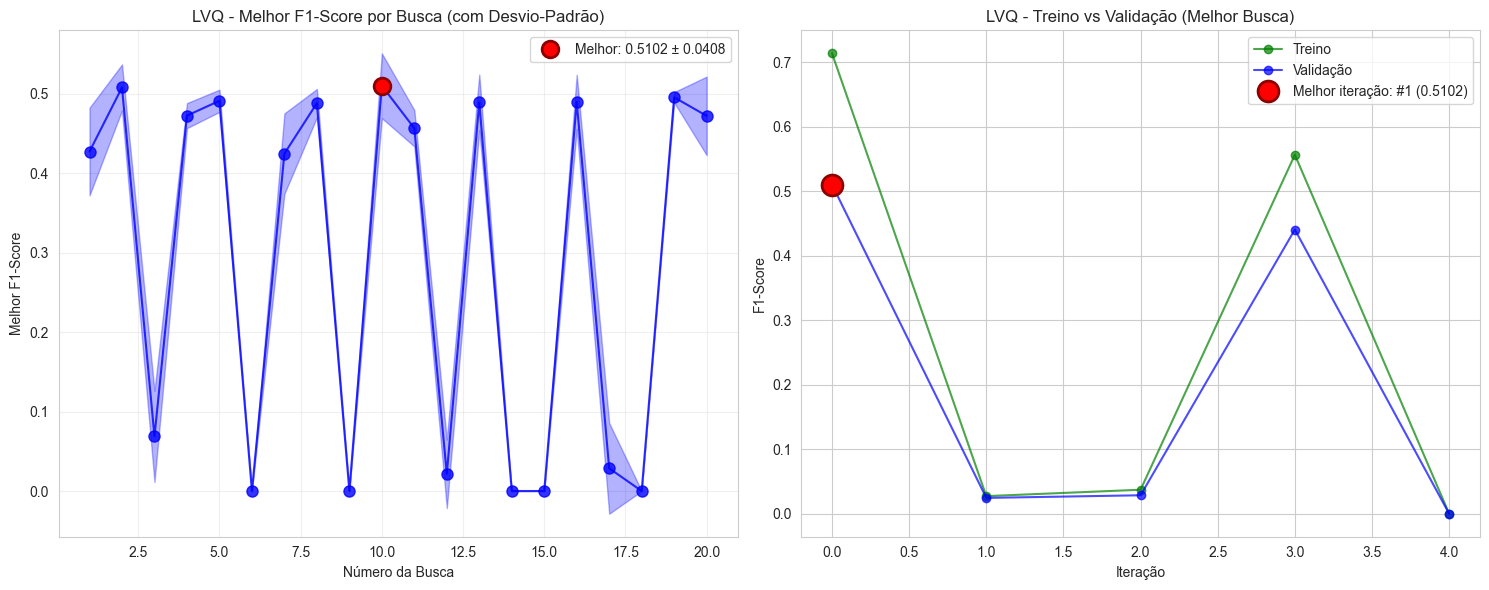

In [17]:
# Registro de Desempenho - plotar evolução da busca
plot_search_history(all_searches, search, MODEL_NAME)

In [23]:
# ======================================================================
# ANÁLISE DAS MELHORES CONFIGURAÇÕES ENCONTRADAS
# ======================================================================

print(f"=== MELHORES CONFIGURAÇÕES ENCONTRADAS POR BUSCA - {MODEL_NAME} ===")

# Extrair os melhores resultados de cada busca
best_configs = []

for i, search_result in enumerate(all_searches):
    config = {
        'Busca': i + 1,
        'F1_Score': search_result['best_score'],
        **search_result['best_params']
    }
    best_configs.append(config)

# Criar DataFrame e exibir top configs
results_df = pd.DataFrame(best_configs)
results_df = results_df.sort_values('F1_Score', ascending=False).round(4)

print(f"\nTop configurações (de {len(results_df)} buscas):")
print(results_df.to_string(index=False))

print(f"\nEstatísticas dos F1-Scores encontrados:")
print(f"  Média: {results_df['F1_Score'].mean():.4f}")
print(f"  Mediana: {results_df['F1_Score'].median():.4f}")
print(f"  Desvio padrão: {results_df['F1_Score'].std():.4f}")
print(f"  Min: {results_df['F1_Score'].min():.4f}")
print(f"  Max: {results_df['F1_Score'].max():.4f}")

=== MELHORES CONFIGURAÇÕES ENCONTRADAS POR BUSCA - LVQ ===

Top configurações (de 20 buscas):
 Busca  F1_Score  learning_rate  n_epochs  prototypes_per_class
    10    0.5102         0.0281       676                    68
     2    0.5080         0.1011       956                    66
    19    0.4956         0.1107       542                    75
     5    0.4912         0.0975       948                    76
    16    0.4899         0.0390        56                    71
    13    0.4893         0.0249       447                    31
     8    0.4883         0.0673       837                    64
     4    0.4726         0.0074        68                    21
    20    0.4723         0.0449       977                    37
    11    0.4567         0.2402       578                    71
     1    0.4273         0.2683       514                    77
     7    0.4248         0.2557       241                    58
     3    0.0688         0.2971       536                    38
    17    

## 6. SALVAR RESULTADOS DE BUSCA

In [18]:

search_df = save_search_results(
    model_name=MODEL_NAME,
    model_search=search,
    model_all_searches=all_searches,
    n_searches=N_SEARCHES,
    n_iter_per_search=N_ITER_PER_SEARCH,
    scoring='f1',
    cv_folds=5,
    top_params_columns=['prototypes_per_class', 'n_epochs', 'learning_rate'],
    searches_folder=SEARCHES_FOLDER
)

=== SALVANDO RESULTADOS DA BUSCA - LVQ ===
  ✅ Todos os Resultados salvos: searches\lvq_all_searches.csv
  Total de configurações testadas: 100
  ✅ Resumo salvo: searches\lvq_search_summary.json

--- ESTATÍSTICAS DA BUSCA LVQ ---
Melhor F1-Score: 0.5102
Desvio padrão do melhor: 0.0408
F1-Score médio geral: 0.1153
F1-Score mínimo: 0.0000
F1-Score máximo: 0.5102


### 6.2 Carregar Resultado de Busca (Opcional)

In [ ]:
loaded_results = load_search_results(MODEL_NAME)

In [ ]:
# Plotar a história da busca a partir dos resultados carregados
plot_search_history_from_loaded(loaded_results, MODEL_NAME)

### 6.3 Definir Melhores Params e CV score

In [ ]:
# Definir Melhores Parâmetros para Uso Posterior
if 'loaded_results' in locals():
    best_params = get_best_params_from_saved(MODEL_NAME)
    if best_params:
        print(f"✅ Parâmetros carregados: {best_params}")
    best_score = loaded_results['summary']['best_overall_score']
    print(f"✅ Melhor F1-Score carregado: {best_score:.4f}")
else:
    best_params = search.best_params_
    best_score = search.best_score_
    print(f"✅ Usando parâmetros da busca atual: {best_params}")
    print(f"✅ Melhor F1-Score da busca atual: {best_score:.4f}")

## 7. TREINAR MODELO FINAL E SALVAR

In [ ]:
# Treinamento Final com melhores hiperparâmetros

best_model = MODEL_CLASS(random_state=RANDOM_STATE_MODEL, **best_params)
best_model.fit(X_train_scaled, y_train)


In [ ]:

# Save the trained model immediately after training
os.makedirs(MODELS_FOLDER, exist_ok=True)

model_path = os.path.join(MODELS_FOLDER, f'{MODEL_NAME.lower().replace(" ", "_")}_model.joblib')
dump(best_model, model_path)
print(f"✅ Model saved to: {model_path}")

## 8. AVALIAÇÃO FINAL E SALVAMENTO DOS RESULTADOS

In [ ]:
# Carregar modelo (Opcional)
loaded_model = load(f'models/{MODEL_NAME.lower()}_trained.joblib')

In [ ]:
print(f"=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - {MODEL_NAME} ===")

# Criar pastas se não existirem
os.makedirs(RESULTS_FOLDER, exist_ok=True)

# Avaliação completa do modelo
print("\nAvaliando performance do modelo...")

# Usar datasets completos para avaliação final
X_train_eval = X_train_scaled
y_train_eval = y_train
X_test_eval = X_test_scaled
y_test_eval = y_test

# Avaliar modelo usando função do módulo
train_metrics, test_metrics, y_test_pred = evaluate_model(
    best_model, X_train_eval, X_test_eval, y_train_eval, y_test_eval, MODEL_NAME
)

In [ ]:
classification_report(y_test, y_test_pred, zero_division=0)

### 8.2 Visualize Confusion Matrix

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'{MODEL_NAME} - Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 8.3 Save Final Results

In [ ]:
# Salvar resultados finais usando função do módulo
model_final_results = save_final_results(
    model_name=MODEL_NAME,
    best_params=best_params,
    best_score=best_score,
    train_metrics=train_metrics,
    test_metrics=test_metrics,
    y_pred=y_test_pred,
    y_test=y_test_eval,
    X_train_scaled=X_train_eval,
    X_test_scaled=X_test_eval,
    results_folder=RESULTS_FOLDER
)

# Mostrar resumo final
print(f"\n--- RESUMO FINAL {MODEL_NAME} ---")
print(f"F1-Score CV: {model_final_results['best_cv_score']:.4f}")
print(f"F1-Score Teste: {test_metrics['f1']:.4f}")
print(f"Acurácia Teste: {test_metrics['accuracy']:.4f}")
print(f"Precisão Teste: {test_metrics['precision']:.4f}")
print(f"Recall Teste: {test_metrics['recall']:.4f}")
print(f"G-Mean Teste: {test_metrics['gmean']:.4f}")
if test_metrics.get('auc_roc'):
    print(f"AUC-ROC Teste: {test_metrics['auc_roc']:.4f}")

print(f"\nAvaliação do {MODEL_NAME} concluída com sucesso!")
print(f"Resultados salvos em: {RESULTS_FOLDER}/")
print(f"Modelo salvo em: {MODELS_FOLDER}/")
print(f"Histórico de busca salvo em: {SEARCHES_FOLDER}/")